# Composition-dependent surface adsorption

One may have a system whereby the adsorption of a gas-phase species is dependent on the composition of the particle or film surface. MultilayerPy can facilitate this in the model building and optimisation process. 

Let's build the same simple reactive system used in other tutorials: `oleic acid + ozone --> products`

Now, let's say that ozone does not adsorb to the product molecules as readily as it does to pure oleic acid. This is accounted for in a separate `alpha_s0` parameter for ozone on a product surface (the surface accommodation coefficient on a free surface). Composition-dependent surface adsorption is defined when defining specific model components.

Surface-dependent surface adsorption is defined below:

$$
\alpha_{s,0,X_{i}} = \sum_{j} \alpha_{s,0,X_{i},Y_{j}}\theta_{ss,Y_{j}}
$$

Where $\alpha_{s,0,X_{i}}$ is the overall surface accommodation coefficient for gas $X_{i}$, $\alpha_{s,0,X_{i},Y_{j}}$ is the surface accommodation coefficent of $X_{i}$ on a surface of pure $Y_{j}$ and $\theta_{ss,Y_{j}}$ is the fractional surface area of $Y_{j}$.

The initial code is the same as in other tutorial examples:

In [1]:
# import necessary packages
import numpy as np
import multilayerpy
import multilayerpy.build as build 
import multilayerpy.simulate as simulate
import multilayerpy.optimize as optimize

# check the version
print(multilayerpy.__version__)

    
    MultilayerPy - build, run and optimise kinetic multi-layer models for 
    aerosol particles and films.
    
    Copyright (C) 2022 Adam Milsom

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
    Version: 0.0.2dev
    
    

0.0.2dev


In [2]:
# import classes needed to build the model
from multilayerpy.build import ModelType, ReactionScheme, DiffusionRegime, ModelComponent

# define the model type (spherical geometry)
mod_type = ModelType('km-sub','spherical')

# build the reaction tuple list, in this case only 1 tuple in the list (for 1 reaction)
# component 1 (oleic acid) reacts with component 2 (ozone)
reaction_tuple_list = [(1,2)]

# build the product tuple list, only component 3 (products) is a product
# a tuple with a single value inside is defined (value,)
product_tuple_list = [(3,)]

# now construct the reaction scheme
# we can give it a name and define the nuber of components as below
reaction_scheme = ReactionScheme(mod_type,name='Oleic acid ozonolysis',
                                                   reactants=reaction_tuple_list,
                                                products=product_tuple_list)

# let's print out a representation of the reaction scheme
reaction_scheme.display()

#########################################################
Reaction scheme: Oleic acid ozonolysis
Model type: km-sub
** No stoichiometry shown **
R1: 1 + 2 -----> 3 
#########################################################


In [3]:
# Adding in model components
# oleic acid
OA = ModelComponent(1,reaction_scheme,name='Oleic acid')

#================================

# ozone, declare that it is a gas
# ***HERE IS WHERE COMPOSITION-DEPENDENT ADSORPTION IS DEFINED***
O3 = ModelComponent(2,reaction_scheme,gas=True,name='Ozone',comp_dependent_adsorption=True) 

#================================

# products
prod = ModelComponent(3,reaction_scheme, name='Reaction products')

# collect into a dictionary
model_components_dict = {'1':OA,
                        '2':O3,
                        '3':prod}

# making the diffusion dictionary
diff_dict = {'1' : None,
             '2': None,
             '3':None}  

# make diffusion regime
diff_regime = DiffusionRegime(mod_type,model_components_dict,diff_dict=diff_dict)

# call it to build diffusion code ready for the builder
diff_regime()

In [4]:
# Now construct the model and identify the required parameters

# import ModelBuilder class
from multilayerpy.build import ModelBuilder

# create the model object, ignore [1,2,3] etc at the end
model = ModelBuilder(reaction_scheme,model_components_dict,diff_regime)

# build the model. Will save a file, don't include the date in the model filename
model.build(date=False)

# print out the parameters required for the model to run
print(model.req_params)

{'Db_1', 'Td_2', 'delta_2', 'Db_3', 'Db_2', 'delta_1', 'delta_3', 'k_1_2', 'alpha_s_0_2_1', 'T', 'H_2', 'w_2', 'alpha_s_0_2_3', 'k_1_2_surf', 'Xgs_2'}


### Additional required input parameters

Notice that `alpha_s_0_2_1` and `alpha_s_0_2_3` are included in the list of required parameters. `alpha_s_0_2_1` stands for "surface adsorption coefficient of `2` on pure `1` and has a value between 0 and 1". These parameters would not be required if composition-dependent adsorption was not imposed for component `2`.

These parameters need to be supplied when running the model. For the purpose of this tutorial, let's say `alpha_s_0_2_3` is  small (`4.2e-5`) compared with `alpha_s_0_2_1` (`4.2e-4`). In other words, ozone will adsorb less to the surface as more product is produced. The diffusivity of all components has also been decreased so that we are in a more surface process-limited regime.

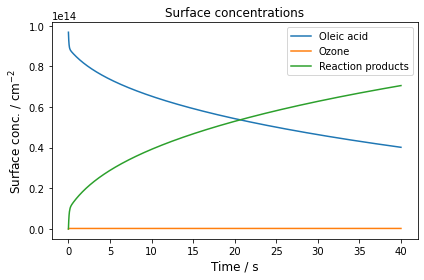

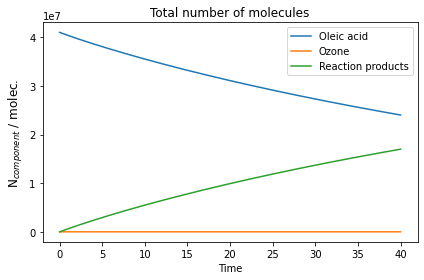

In [5]:
# Build and run the simulation

# import the Simulate class
from multilayerpy.simulate import Simulate

# import the Parameter class
from multilayerpy.build import Parameter

# make the parameter dictionary
param_dict = {'delta_3':Parameter(1e-7),
              'alpha_s_0_2_1':Parameter(4.2e-4),
              'alpha_s_0_2_3':Parameter(4.2e-5),
              'delta_2':Parameter(0.4e-7),
              'Db_2':Parameter(1e-12),
              'delta_1':Parameter(0.8e-7),
              'Db_1':Parameter(1e-12),
              'Db_3':Parameter(1e-12),
              'k_1_2':Parameter(1.7e-15),
              'H_2':Parameter(4.8e-4),
              'Xgs_2': Parameter(7.0e13),
              'Td_2': Parameter(1e-2),
              'w_2':Parameter(3.6e4),
              'T':Parameter(298.0),
              'k_1_2_surf':Parameter(6.0e-12),
             }


# make the simulate object with the model and parameter dictionary
sim = Simulate(model,param_dict)

# define required parameters
n_layers = 10
rp = 0.2e-4 # radius in cm
time_span = [0,40] # in s
n_time = 999 # number of timepoints to save to output

#spherical V and A
# use simulate.make_layers function
V, A, layer_thick = simulate.make_layers(mod_type,n_layers,rp)

# initial conc. of everything

bulk_conc_dict = {'1':1.21e21,'2':0,'3':0} # key=model component number, value=bulk conc
surf_conc_dict = {'1':9.68e13,'2':0,'3':0} # key=model component number, value=surf conc

y0 = simulate.initial_concentrations(mod_type,bulk_conc_dict,surf_conc_dict,n_layers) 
    
# now run the model
output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)

%matplotlib inline
# plot the model
sim.plot()

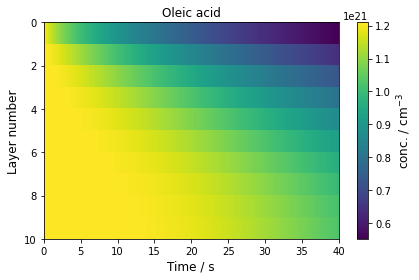

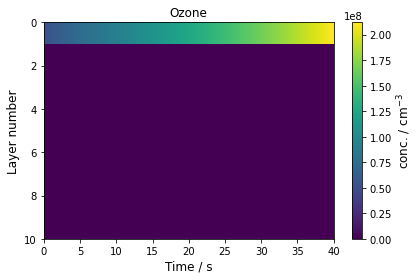

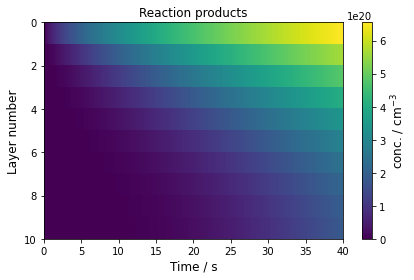

In [6]:
# plot the bulk concentrations
sim.plot_bulk_concs()

### Comparison with and without composition-dependent surface adsorption

The next block of code will compare with and without composition-dependent surface adsorption. 

In [7]:
# make a an empty list for simulate objects, append to later
sim_objs = []

# non-composition-dependent adsorption ozone
O3 = ModelComponent(2,reaction_scheme,gas=True,name='Ozone')   

# composition-dependent adsorption ozone
O3_comp_depend_ads = ModelComponent(2,reaction_scheme,gas=True,name='Ozone_comp_dependent',comp_dependent_adsorption=True)

# 2 parameter dicts for the two models...

# without composition-dependent adsorption
param_dict_without = {'delta_3':Parameter(1e-7),
              'alpha_s_0_2':Parameter(4.2e-4),
              'delta_2':Parameter(0.4e-7),
              'Db_2':Parameter(1e-12),
              'delta_1':Parameter(0.8e-7),
              'Db_1':Parameter(1e-12),
              'Db_3':Parameter(1e-12),
              'k_1_2':Parameter(1.7e-15),
              'H_2':Parameter(4.8e-4),
              'Xgs_2': Parameter(7.0e13),
              'Td_2': Parameter(1e-2),
              'w_2':Parameter(3.6e4),
              'T':Parameter(298.0),
              'k_1_2_surf':Parameter(6.0e-12),
             }

# with composition-dependent adsorption
param_dict_with = {'delta_3':Parameter(1e-7),
              'alpha_s_0_2_1':Parameter(4.2e-4),
              'alpha_s_0_2_3':Parameter(4.2e-6),
              'delta_2':Parameter(0.4e-7),
              'Db_2':Parameter(1e-12),
              'delta_1':Parameter(0.8e-7),
              'Db_1':Parameter(1e-12),
              'Db_3':Parameter(1e-12),
              'k_1_2':Parameter(1.7e-15),
              'H_2':Parameter(4.8e-4),
              'Xgs_2': Parameter(7.0e13),
              'Td_2': Parameter(1e-2),
              'w_2':Parameter(3.6e4),
              'T':Parameter(298.0),
              'k_1_2_surf':Parameter(6.0e-12),
             }

O3_model_component_objects = [O3,O3_comp_depend_ads]
param_dict_list = [param_dict_without,param_dict_with]
mod_name_ext = ['without','with']

# for each "version" of ozone (without/with composition-dependent adsorption),run the model
for index, component in enumerate(O3_model_component_objects): 
    
    O3_test = component
    model_comps_dict = {'1':OA,
                        '2':O3_test,
                        '3':prod}
    
    # diffusion regime and reaction scheme are the same and defined previously in this notebook, so I'll skip those steps
    # (reusing building blocks)
    
     # create the model object for this model iteration
    model = ModelBuilder(reaction_scheme,model_comps_dict,diff_regime)
    model.build(date=False,name_extention=mod_name_ext[index])
    
    #print(model.req_params) # uncomment to print required parameters
    #print(param_dict["alpha_s_0_2"]) # uncomment to check value of alpha_s_0_2
    
    # make simulate object and run it, use same params as before
    # The extra alpha_S0_2_1 and alpha_S0_2_3 params will be ignored by the non-composition-dependent adsorption simulation
    
    # make the simulate object with the model and parameter dictionary
    sim = Simulate(model,param_dict_list[index])

    # define required parameters
    n_layers = 10
    rp = 0.2e-4 # radius in cm
    time_span = [0,40] # in s
    n_time = 999 # number of timepoints to save to output
    


    #spherical V and A
    # use simulate.make_layers function
    V, A, layer_thick = simulate.make_layers(mod_type,n_layers,rp)

    # initial conc. of everything

    bulk_conc_dict = {'1':1.21e21,'2':0,'3':0} # key=model component number, value=bulk conc
    surf_conc_dict = {'1':9.68e13,'2':0,'3':0} # key=model component number, value=surf conc

    y0 = simulate.initial_concentrations(mod_type,bulk_conc_dict,surf_conc_dict,n_layers) 

    # now run the model
    output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)

    # append the simulate object to the list
    sim_objs.append(sim)
    

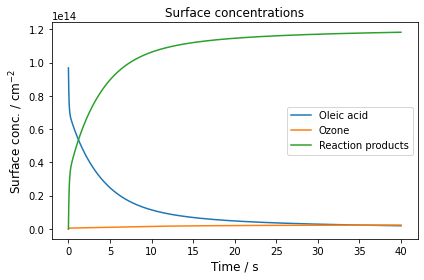

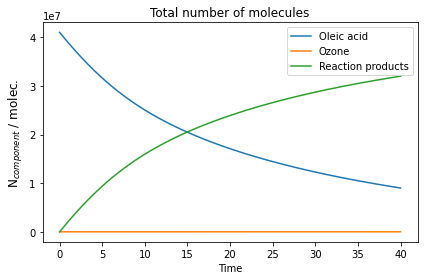

In [8]:
# Plotting without composition-dependent adsoprtion
sim = sim_objs[0]
sim.plot()

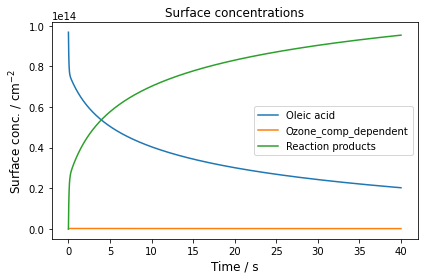

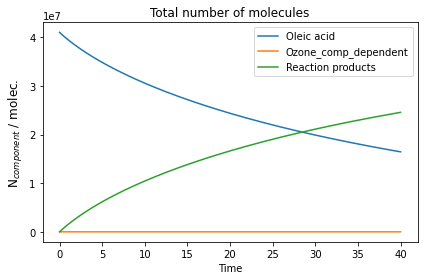

In [9]:
# plotting with composition-dependent adsorption
sim = sim_objs[1]
sim.plot()

### Summary

It is clear that with composition-dependent diffusion the decay of oleic acid at the surface of the particle slows down as more product appears at the surface. This appears to also slow down the total rate of oleic acid loss, suggesting surface adsorption in this system affect the decay of the condensed phase reactant somewhat. 

Surface-dependent surface adsorption can be extended to more complex systems. 